# Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Library

In [2]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD

Using TensorFlow backend.


# Parameter

In [0]:
TARGET_SIZE = (299, 299) #fixed size for InceptionV3
BATCH_SIZE = 32
FC_SIZE = 1024
LOWER_LAYERS = 172
CLASSES = ['Fire','Robbery','Safe']
n_classes = 3
nb_train_samples = 3360
nb_val_samples = 840
base_path = '/content/drive/My Drive/computer vision/accident detection'
#base_path = ''
data_dir = base_path + '/train_test'
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'

# Fit into ImageDataGenerator

In [4]:
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True)

test_datagen = ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
  train_dir,
  target_size=TARGET_SIZE,
  batch_size=BATCH_SIZE)

validation_generator = test_datagen.flow_from_directory(
  test_dir,
  target_size=TARGET_SIZE,
  batch_size=BATCH_SIZE)

Found 3360 images belonging to 3 classes.
Found 840 images belonging to 3 classes.


# Fine-tuning

In [5]:
base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(FC_SIZE, activation='relu')(x) # new FC layer
predictions = Dense(n_classes, activation='softmax')(x) # new softmax layer
model = Model(input=base_model.input, output=predictions)
for layer in model.layers[:LOWER_LAYERS]:
    layer.trainable = False # set the lower layers are not trainable
for layer in model.layers[LOWER_LAYERS:]:
    layer.trainable = True # set the higher layers trainable
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


# Train model

## Use checkpoint to save progress

In [0]:
filepath = base_path + "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [10]:
# fit the model
N=10
history_tl = model.fit_generator(train_generator,
                                nb_epoch=N,
                                samples_per_epoch=nb_train_samples,
                                class_weight='auto',
                                callbacks = callbacks_list, 
                                verbose=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., class_weight="auto", callbacks=[<keras.ca..., verbose=1, steps_per_epoch=105, epochs=10)`
  import sys


Epoch 1/10
 14/105 [===>..........................] - ETA: 2:07 - loss: 0.4328 - acc: 0.8705

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


105/105 [==============================] - 142s 1s/step - loss: 0.3991 - acc: 0.8854

Epoch 00001: acc improved from 0.81429 to 0.88542, saving model to /content/drive/My Drive/computer vision/accident detectionmodel.h5
Epoch 2/10
105/105 [==============================] - 142s 1s/step - loss: 0.3387 - acc: 0.8967

Epoch 00002: acc improved from 0.88542 to 0.89673, saving model to /content/drive/My Drive/computer vision/accident detectionmodel.h5
Epoch 3/10
105/105 [==============================] - 140s 1s/step - loss: 0.3068 - acc: 0.9021

Epoch 00003: acc improved from 0.89673 to 0.90208, saving model to /content/drive/My Drive/computer vision/accident detectionmodel.h5
Epoch 4/10
105/105 [==============================] - 140s 1s/step - loss: 0.2716 - acc: 0.9179

Epoch 00004: acc improved from 0.90208 to 0.91786, saving model to /content/drive/My Drive/computer vision/accident detectionmodel.h5
Epoch 5/10
105/105 [==============================] - 140s 1s/step - loss: 0.2524 - acc

In [0]:
model.save(base_path+'/inception.model')

# Evaluate model

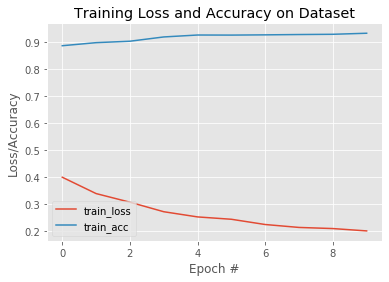

In [11]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_tl.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history_tl.history["acc"], label="train_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [12]:
evalute = model.evaluate_generator(validation_generator,
                                   verbose=1)
print(evalute[1])

27/27 [==============================] - 33s 1s/step
0.9202380952380952


# Load Model

In [0]:
from keras.models import load_model
model = load_model(base_path+'/inception.model')

# Prediction

Images: 2.jpeg, Predict: Fire
Images: 5.jpeg, Predict: Robbery
Images: 4.jpeg, Predict: Fire
Images: 3.jpeg, Predict: Fire
Images: 1.jpeg, Predict: Fire
Images: 8.jpg, Predict: Safe
Images: 7.jpg, Predict: Safe


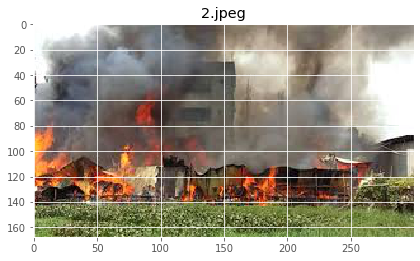

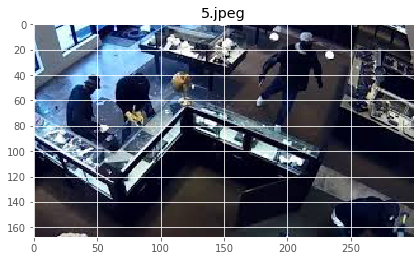

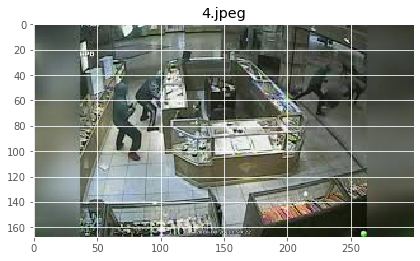

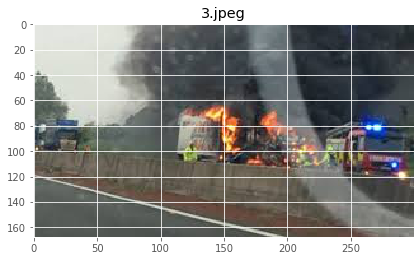

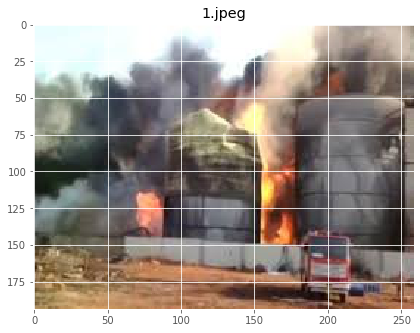

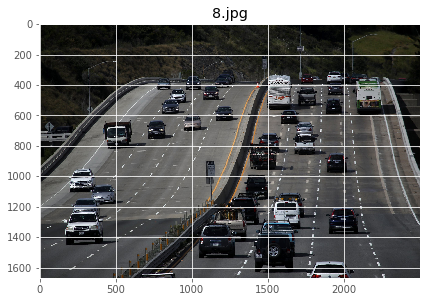

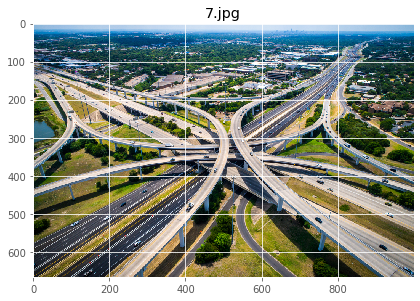

In [53]:
import cv2
import skimage.transform
from skimage import io
from keras.preprocessing import image
predict_dir = base_path+'/predict'
for root, dirs, files in os.walk(predict_dir):
  for file in files:
    img = io.imread(os.path.join(root, file))
    plt.figure(figsize=(15,10))
    plt.subplot(1,2,1)
    plt.title(file)
    plt.imshow(img)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    preds = model.predict(img)
    j = np.argmax(preds)
    print("Images: "+ file+", Predict: "+CLASSES[j])